In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
#Training on 20% of the dataset
# Load the featurized and categorized data
train_csv_path = '/kaggle/input/training-dataset/train_malicious_phish.csv'
val_csv_path = '/kaggle/input/validation-dataset/val_malicious_phish.csv'
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Convert 'TRUE'/'FALSE' to 1/0
bool_columns = ['at_symbol_0', 'at_symbol_1', 'redirection_0', 'redirection_1',
                'has_ip_0', 'has_ip_1', 'has_https_0', 'has_https_1',
                'is_tinyurl_0', 'is_tinyurl_1']

for col in bool_columns:
    train_df[col] = train_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)
    val_df[col] = val_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)

# Separate features and labels
X_train = train_df.drop(columns=['type', 'url'])
y_train = train_df['type']

X_val = val_df.drop(columns=['type', 'url'])
y_val = val_df['type']

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.2, stratify=y_train, random_state=42)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_sub, y_train_sub)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)

# Print results for each trial
cv_results = grid_search.cv_results_
for i in range(len(cv_results['params'])):
    print(f"Trial {i+1}:")
    print(f"Parameters: {cv_results['params'][i]}")
    print(f"Training Accuracy: {cv_results['mean_train_score'][i]:.4f}")
    print(f"Validation Accuracy: {cv_results['mean_test_score'][i]:.4f}")
    print("")

print("Best Parameters Found: ", grid_search.best_params_)
print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("F1 Score (Validation):", f1_score(y_val, y_pred_val, average='weighted'))
print("\nClassification Report on Validation Data:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Trial 1:
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Training Accuracy: 0.8297
Validation Accuracy: 0.8255

Trial 2:
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training Accuracy: 0.8296
Validation Accuracy: 0.8255

Trial 3:
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Training Accuracy: 0.8289
Validation Accuracy: 0.8255

Trial 4:
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training Accuracy: 0.8289
Validation Accuracy: 0.8250

Trial 5:
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Training Accuracy: 0.8289
Validation Accuracy: 0.8252

Trial 6:
Par

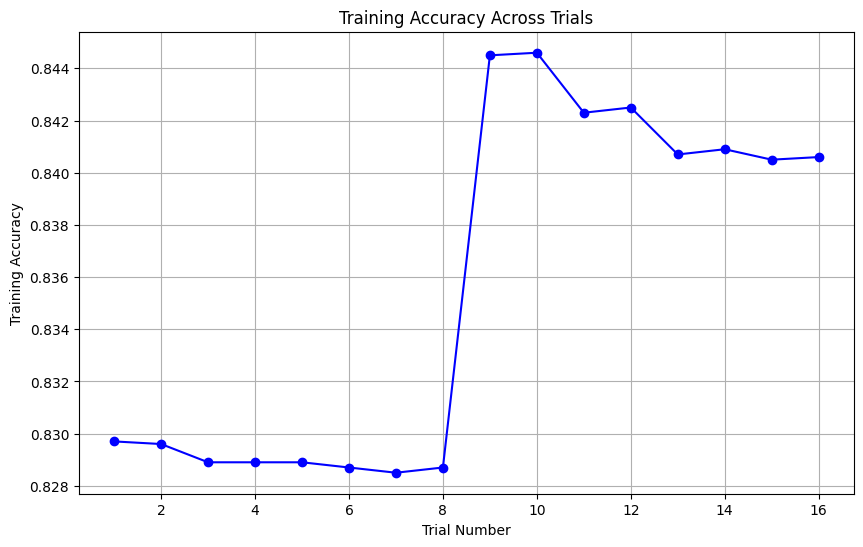

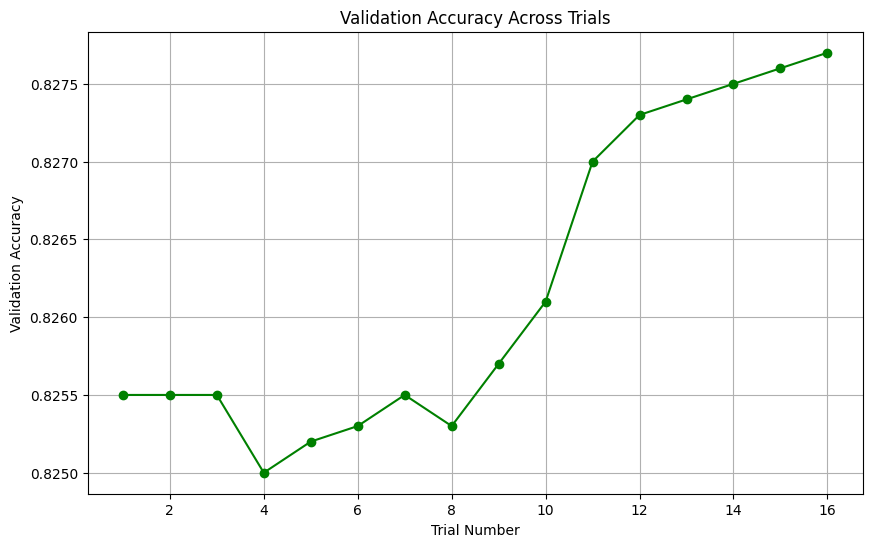

In [ ]:
#Graphing hyperparameters and accuracy after the fact

import matplotlib.pyplot as plt

# Data from the trials
trials = list(range(1, 17))
training_accuracy = [
    0.8297, 0.8296, 0.8289, 0.8289, 0.8289, 0.8287, 0.8285, 0.8287,
    0.8445, 0.8446, 0.8423, 0.8425, 0.8407, 0.8409, 0.8405, 0.8406
]
validation_accuracy = [
    0.8255, 0.8255, 0.8255, 0.8250, 0.8252, 0.8253, 0.8255, 0.8253,
    0.8257, 0.8261, 0.8270, 0.8273, 0.8274, 0.8275, 0.8276, 0.8277
]

# Plotting training accuracy
plt.figure(figsize=(10, 6))
plt.plot(trials, training_accuracy, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy Across Trials')
plt.xlabel('Trial Number')
plt.ylabel('Training Accuracy')
plt.grid(True)
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(trials, validation_accuracy, marker='o', linestyle='-', color='g')
plt.title('Validation Accuracy Across Trials')
plt.xlabel('Trial Number')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
import joblib

# Function to featurize a single URL
def featurize_url(url):
    features = {
        'at_symbol_0': 0,
        'at_symbol_1': 0,
        'redirection_0': 0,
        'redirection_1': 0,
        'has_ip_0': 0,
        'has_ip_1': 0,
        'has_https_0': 0,
        'has_https_1': 0,
        'is_tinyurl_0': 0,
        'is_tinyurl_1': 0,
        'subdomains': 0,
        'url_length': len(url),
        'word_count': len(url.split('.'))
    }

    if '@' in url:
        features['at_symbol_1'] = 1
    else:
        features['at_symbol_0'] = 1

    if '//' in url:
        features['redirection_1'] = 1
    else:
        features['redirection_0'] = 1

    ip_pattern = re.compile(r'(\d{1,3}\.){3}\d{1,3}')
    if ip_pattern.search(url):
        features['has_ip_1'] = 1
    else:
        features['has_ip_0'] = 1

    if 'https' in url:
        features['has_https_1'] = 1
    else:
        features['has_https_0'] = 1

    tinyurl_pattern = re.compile(r'tinyurl\.com|bit\.ly|goo\.gl')
    if tinyurl_pattern.search(url):
        features['is_tinyurl_1'] = 1
    else:
        features['is_tinyurl_0'] = 1

    # Calculate subdomains
    features['subdomains'] = url.count('.') - 1

    return pd.DataFrame([features])

# Load the featurized and categorized data
train_csv_path = '/kaggle/input/training-dataset/train_malicious_phish.csv'
val_csv_path = '/kaggle/input/validation-dataset/val_malicious_phish.csv'
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Convert 'TRUE'/'FALSE' to 1/0
bool_columns = ['at_symbol_0', 'at_symbol_1', 'redirection_0', 'redirection_1',
                'has_ip_0', 'has_ip_1', 'has_https_0', 'has_https_1',
                'is_tinyurl_0', 'is_tinyurl_1']

for col in bool_columns:
    train_df[col] = train_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)
    val_df[col] = val_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)

# features
train_df['subdomains'] = train_df['url'].apply(lambda x: x.count('.') - 1)
val_df['subdomains'] = val_df['url'].apply(lambda x: x.count('.') - 1)
train_df['url_length'] = train_df['url'].apply(len)
val_df['url_length'] = val_df['url'].apply(len)
train_df['word_count'] = train_df['url'].apply(lambda x: len(x.split('.')))
val_df['word_count'] = val_df['url'].apply(lambda x: len(x.split('.')))

# ensure the same feature order for training
feature_order = ['at_symbol_0', 'at_symbol_1', 'redirection_0', 'redirection_1',
                 'has_ip_0', 'has_ip_1', 'has_https_0', 'has_https_1',
                 'is_tinyurl_0', 'is_tinyurl_1', 'subdomains', 'url_length', 'word_count']

# separate features and labels
X_train = train_df[feature_order]
y_train = train_df['type']

X_val = val_df[feature_order]
y_val = val_df['type']


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# best hyperparameters
best_model = RandomForestClassifier(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)
best_model.fit(X_train, y_train)


y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report on Validation Data:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))

# Save the best model
joblib.dump(best_model, 'best_random_forest_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Function to predict if a URL is malicious
def predict_url(url, model, encoder):
    features = featurize_url(url)
    features = features[feature_order]
    prediction = model.predict(features)
    return encoder.inverse_transform(prediction)[0]

def interactive_prediction(url):
    model = joblib.load('best_random_forest_model.pkl')
    encoder = joblib.load('label_encoder.pkl')
    result = predict_url(url, model, encoder)
    return result

url_to_predict = "http://google.com"
prediction = interactive_prediction(url_to_predict)
print(f"The URL '{url_to_predict}' is predicted to be: {prediction}")


Training Accuracy: 0.7212315146117109
Validation Accuracy: 0.7192853139228649

Classification Report on Validation Data:
              precision    recall  f1-score   support

      benign       0.75      0.92      0.83     85778
  defacement       0.66      0.42      0.51     19104
     malware       0.61      0.35      0.44      6521
    phishing       0.47      0.22      0.30     18836

    accuracy                           0.72    130239
   macro avg       0.62      0.48      0.52    130239
weighted avg       0.69      0.72      0.69    130239

The URL 'http://google.com' is predicted to be: benign
